In [22]:
import pandas as pd

# Load dataset without headers (since original file lacks column names)
data = pd.read_csv('/content/100k_a.csv', header=None)

# Assign proper column names manually
data.columns = ['chat_id', 'timestamp', 'username', 'viewer_count', 'chat_text']

# Preview columns and data
print("Columns:", data.columns.tolist())
print(data.head())


Columns: ['chat_id', 'timestamp', 'username', 'viewer_count', 'chat_text']
   chat_id    timestamp   username  viewer_count  chat_text
0        1  33842865744   mithrain           154        156
1        1  33846768288      alptv           166        169
2        1  33886469056   mithrain           587        588
3        1  33887624992       wtcn           589        591
4        1  33890145056  jrokezftw           591        594


In [23]:
# Keep only first 100 rows for testing
data = data.head(100)
print(f"Dataset reduced to {len(data)} rows.")



Dataset reduced to 100 rows.


In [24]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))  # remove URLs
    text = re.sub(r'@\w+', '', text)          # remove mentions
    text = re.sub(r'#\w+', '', text)          # remove hashtags
    text = re.sub(r'\s+', ' ', text)          # normalize spaces
    return text.strip()

# Clean the chat messages
data['cleaned_message'] = data['chat_text'].apply(clean_text)

print("\nCleaned messages:")
print(data[['chat_text', 'cleaned_message']].head())



Cleaned messages:
   chat_text cleaned_message
0        156             156
1        169             169
2        588             588
3        591             591
4        594             594


In [25]:
!pip install transformers

from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Run sentiment analysis row by row (avoiding batch to prevent timeout)
sentiments = [sentiment_pipeline(text)[0] for text in data['cleaned_message']]

# Add sentiment results
data['sentiment_label'] = [s['label'] for s in sentiments]
data['sentiment_score'] = [s['score'] for s in sentiments]

print("\nSentiment results:")
print(data[['cleaned_message', 'sentiment_label', 'sentiment_score']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0



Sentiment results:
  cleaned_message sentiment_label  sentiment_score
0             156        POSITIVE         0.891142
1             169        POSITIVE         0.917682
2             588        POSITIVE         0.822374
3             591        POSITIVE         0.864873
4             594        POSITIVE         0.863392


In [26]:
def map_sentiment(label):
    return 1 if label == 'POSITIVE' else 0

data['sentiment_numeric'] = data['sentiment_label'].apply(map_sentiment)

print("\nMapped sentiment numeric:")
print(data[['cleaned_message', 'sentiment_label', 'sentiment_numeric']].head())



Mapped sentiment numeric:
  cleaned_message sentiment_label  sentiment_numeric
0             156        POSITIVE                  1
1             169        POSITIVE                  1
2             588        POSITIVE                  1
3             591        POSITIVE                  1
4             594        POSITIVE                  1


In [27]:
import tensorflow as tf
from tensorflow.keras import layers

# Feature matrix (viewer_count + sentiment_numeric)
X = data[['viewer_count', 'sentiment_numeric']].values
y = data['sentiment_numeric'].values  # using sentiment_numeric as proxy for satisfaction

# Define simple DNN model
model = tf.keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X, y, epochs=10, verbose=1)

# Predict satisfaction
data['predicted_satisfaction'] = (model.predict(X) > 0.5).astype(int)

print("\nPredicted satisfaction:")
print(data[['cleaned_message', 'viewer_count', 'predicted_satisfaction']].head())


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 773ms/step - accuracy: 0.0092 - loss: 2507.1775
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0061 - loss: 2413.1326     
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0155 - loss: 2214.5369 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0061 - loss: 2173.6855     
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0061 - loss: 1894.0610     
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0061 - loss: 1731.8800     
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0092 - loss: 1688.8271     
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0061 - loss: 1594.6807    
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0092 - loss: 1379.5514     
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0061 - loss: 1223.0599    
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step

Predicted satisfaction:
  cleaned_message  viewer_count  pr

In [28]:
def qos_action(row):
    if row['predicted_satisfaction'] == 0:
        return "Increase bitrate / reduce ads / notify support"
    else:
        return "QoS optimal"

data['qos_action'] = data.apply(qos_action, axis=1)

print("\nQoS Actions:")
print(data[['cleaned_message', 'predicted_satisfaction', 'qos_action']].head())



QoS Actions:
  cleaned_message  predicted_satisfaction  \
0             156                       0   
1             169                       0   
2             588                       0   
3             591                       0   
4             594                       0   

                                       qos_action  
0  Increase bitrate / reduce ads / notify support  
1  Increase bitrate / reduce ads / notify support  
2  Increase bitrate / reduce ads / notify support  
3  Increase bitrate / reduce ads / notify support  
4  Increase bitrate / reduce ads / notify support  


In [30]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 14.9 MB/s eta 0:00:00


In [31]:
# 1️⃣ Import libraries
import pandas as pd
import numpy as np
import re
import emoji
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import pipeline

# 2️⃣ Load dataset
data = pd.read_csv('/content/100k_a.csv', header=None)
data.columns = ['chat_id', 'timestamp', 'username', 'viewer_count', 'chat_text']
print("Dataset loaded with columns:", data.columns.tolist())

# Reduce dataset for testing (optional)
data = data.head(1000)
print(f"Using {len(data)} rows for testing.")

# 3️⃣ Clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

data['cleaned_message'] = data['chat_text'].apply(clean_text)

# 4️⃣ Feature engineering
data['message_length'] = data['cleaned_message'].apply(len)
data['emoji_count'] = data['cleaned_message'].apply(lambda x: len([c for c in x if c in emoji.EMOJI_DATA]))

print("\nSample engineered features:")
print(data[['cleaned_message', 'message_length', 'emoji_count']].head())

# 5️⃣ Sentiment analysis using BERT
sentiment_pipeline = pipeline('sentiment-analysis')

# Run sentiment analysis (batch mode for speed)
sentiments = sentiment_pipeline(data['cleaned_message'].tolist(), batch_size=16)

data['sentiment_label'] = [s['label'] for s in sentiments]
data['sentiment_score'] = [s['score'] for s in sentiments]

# Map sentiment to numeric
data['sentiment_numeric'] = data['sentiment_label'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

print("\nSentiment analysis results:")
print(data[['cleaned_message', 'sentiment_label', 'sentiment_score']].head())

# 6️⃣ Prepare features for DNN
feature_cols = ['viewer_count', 'message_length', 'emoji_count', 'sentiment_score']
X = data[feature_cols].values
y = data['sentiment_numeric'].values  # using sentiment as proxy for satisfaction

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# 7️⃣ Define DNN model
model = tf.keras.Sequential([
    layers.Input(shape=(len(feature_cols),)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 8️⃣ Train model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

# 9️⃣ Evaluate model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

# 🔟 Predict satisfaction on all data
data['predicted_satisfaction'] = (model.predict(X) > 0.5).astype(int)

# QoS decision logic
def qos_action(row):
    if row['predicted_satisfaction'] == 0:
        if row['sentiment_label'] == 'NEGATIVE':
            return "Increase bitrate + check latency + reduce ads"
        else:
            return "Monitor stream health"
    else:
        return "QoS optimal"

data['qos_action'] = data.apply(qos_action, axis=1)

print("\nQoS Actions:")
print(data[['cleaned_message', 'predicted_satisfaction', 'qos_action']].head())

# 🎉 DONE


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Dataset loaded with columns: ['chat_id', 'timestamp', 'username', 'viewer_count', 'chat_text']
Using 1000 rows for testing.

Sample engineered features:
  cleaned_message  message_length  emoji_count
0             156               3            0
1             169               3            0
2             588               3            0
3             591               3            0
4             594               3            0


Device set to use cuda:0



Sentiment analysis results:
  cleaned_message sentiment_label  sentiment_score
0             156        POSITIVE         0.891142
1             169        POSITIVE         0.917682
2             588        POSITIVE         0.822374
3             591        POSITIVE         0.864873
4             594        POSITIVE         0.863392
Train samples: 800, Test samples: 200
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.0056 - loss: 505.0573 - val_accuracy: 0.0100 - val_loss: 353.7325
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0100 - loss: 301.0267 - val_accuracy: 0.0100 - val_loss: 195.5053
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0097 - loss: 165.6038 - val_accuracy: 0.0100 - val_loss: 106.3685
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0100 - loss: 84.8672 - val_accuracy: 0.0250 - val_loss: 29.6173
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2243 - loss: 16.0678 - val_accuracy: 0.9

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      0.99       198

    accuracy                           0.99       200
   macro avg       0.49      0.50      0.50       200
weighted avg       0.98      0.99      0.99       200

 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

QoS Actions:
  cleaned_message  predicted_satisfaction   qos_action
0             156                       1  QoS optimal
1             169                       1  QoS optimal
2             588                       1  QoS optimal
3             591                       1  QoS optimal
4             594                       1  QoS optimal


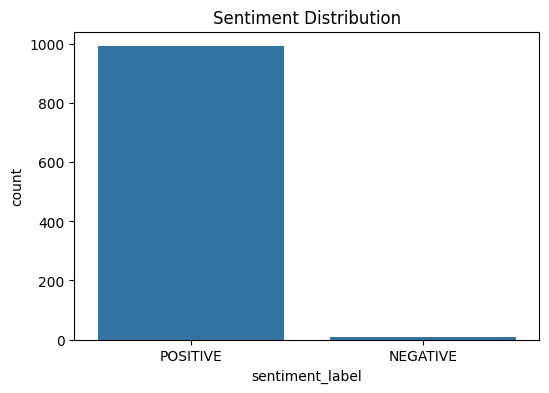

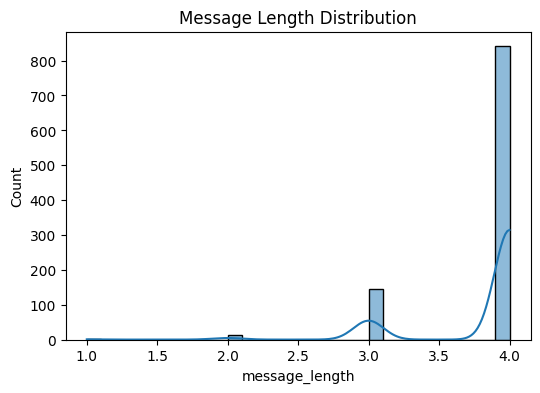

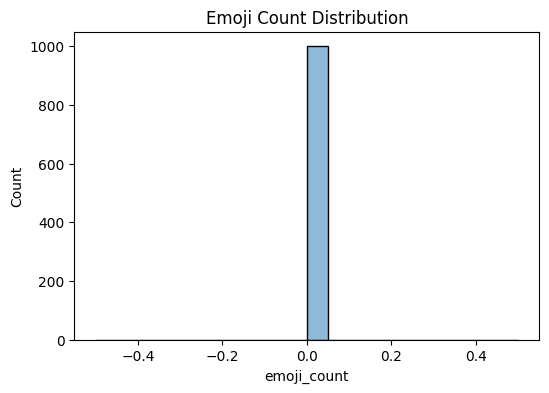

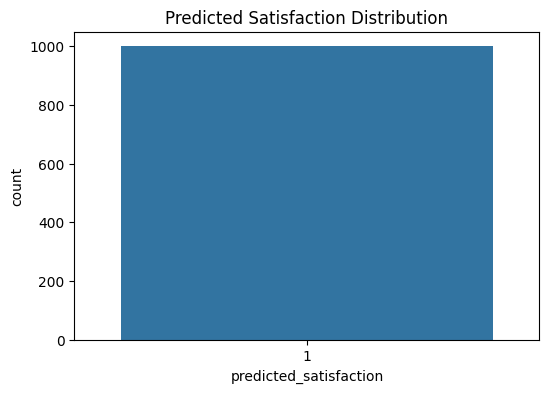

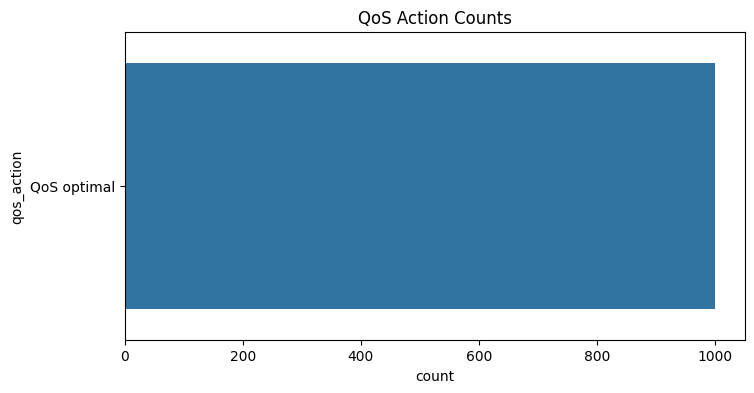

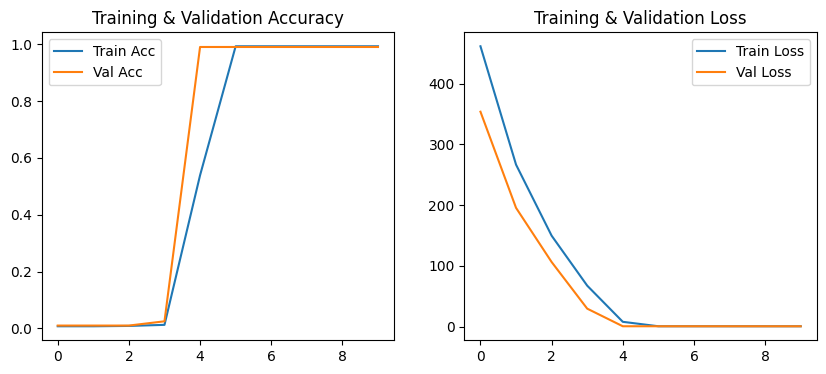

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='sentiment_label')
plt.title("Sentiment Distribution")
plt.show()

# 2️⃣ Message length distribution
plt.figure(figsize=(6,4))
sns.histplot(data['message_length'], bins=30, kde=True)
plt.title("Message Length Distribution")
plt.show()

# 3️⃣ Emoji count distribution
plt.figure(figsize=(6,4))
sns.histplot(data['emoji_count'], bins=20, kde=True)
plt.title("Emoji Count Distribution")
plt.show()

# 4️⃣ Satisfaction prediction distribution
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='predicted_satisfaction')
plt.title("Predicted Satisfaction Distribution")
plt.show()

# 5️⃣ QoS action counts
plt.figure(figsize=(8,4))
sns.countplot(data=data, y='qos_action')
plt.title("QoS Action Counts")
plt.show()

# 6️⃣ Model training history (accuracy & loss)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training & Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training & Validation Loss")

plt.show()
